In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import json
import requests
import srsly
from pathlib import Path

In [ ]:
# Code for grabbing variant props for covariants github
# Data from covariants cluster tables https://github.com/hodcroftlab/covariants/tree/master/cluster_tables, covariants.org

In [2]:
# Set path to target data in data folder
cwd = Path.cwd()
cwd.parent.parent
variant_data_path = cwd.parent.parent / Path("data/raw-variant-data")

In [3]:
cwd.parent.parent

WindowsPath('C:/Users/ehug0006/emu/renewal-wpr-analysis')

In [4]:
# specify variant dictionary
variant_data_dict = {}
temp_dict = {}

# for loop to read through data paths in folders, grab json files and add them to dictionary
for p in variant_data_path.iterdir():
    variant_string = p.stem
    variant_name = variant_string.split('_')[0].replace('.','_')
    variant_dict = srsly.read_json(p)
    variant_data_dict[variant_name] = variant_dict

In [5]:
# check each variant dict key has been added
keysList = list(variant_data_dict.keys())
print(keysList)
# Note names are nextstrain calde names at this point and WHO VOC naming

['20H_Beta_V2', '20I_Alpha_V1', '21A_Delta', '21I_Delta', '21J_Delta', '21K_Omicron', '21L_Omicron', '22A_Omicron', '22B_Omicron']


In [6]:
# create dataframe from nested variant dictionary
df = pd.DataFrame()

for variant,country in variant_data_dict.items():
    for c in country:
        new_df = pd.DataFrame(country[c])
        new_df['country'] = c
        new_df['nextclade_variant'] = variant
        df = pd.concat([df, new_df])

In [ ]:
# lets creare a new column that adds more common variant names

In [7]:

# Define the function to categorise names
def variant_rename(variant_name):
    if variant_name == '20H_Beta_V2':
        return 'Beta'
    elif variant_name == '20I_Alpha_V1':
        return 'Alpha'
    elif variant_name == '21A_Delta':
        return 'Delta'
    elif variant_name == '21I_Delta':
        return 'Delta'
    elif variant_name == '21J_Delta':
        return 'Delta'
    elif variant_name == '21K_Omicron':
        return 'Omicron_BA1_2'
    elif variant_name == '21L_Omicron':
        return 'Omicron_BA1_2'
    elif variant_name == '22A_Omicron':
        return 'Omicron_BA4'
    else:
        return 'Omicron_BA5'

# Apply the function to the Age column using the apply() function
df['variant'] = df['nextclade_variant'].apply(variant_rename)

In [8]:
# inspect df
df = df.drop('nextclade_variant', axis=1)

In [9]:
df = df.groupby(['country','week','variant','total_sequences'])['cluster_sequences'].sum().reset_index()

In [10]:
df['variant_prop'] = df['cluster_sequences']/df['total_sequences']

In [11]:
# select countries
countries = ['Malaysia','Philippines','Vietnam']

df_analysis = df.loc[df['country'].isin(countries)]

In [127]:
# identify week first time variant appears - i.e. prop > 0
threshold = 0.0
emergence_df = df_analysis.loc[df_analysis.variant_prop>threshold].groupby(['country','variant']).head(1)

# save as a csv
#emergence_df.to_csv(cwd.parent.parent / Path("data/variant-data/variant-emergence.csv"))

In [12]:
# identify week first time variant proportion goes above a threshold and there is reasonable sized sampling, lets say 50 sequences total
threshold = 0.5
number = 20

prev_df = df_analysis.loc[(df_analysis.variant_prop>threshold) & (df_analysis.total_sequences>number)].groupby(['country','variant']).head(1)

# save as a csv
prev_df.to_csv(cwd.parent.parent / Path("data/variant-data/variant-prevalence.csv"))

In [15]:
prev_df.head(12)

,country,week,variant,total_sequences,cluster_sequences,variant_prop
23274,Malaysia,2021-06-07,Delta,71,51,0.718310
23359,Malaysia,2021-12-20,Omicron_BA1_2,1132,752,0.664311
23445,Malaysia,2022-07-04,Omicron_BA5,1475,1035,0.701695
28918,Philippines,2021-03-15,Beta,791,406,0.513274
28973,Philippines,2021-07-19,Delta,1141,778,0.681858
29034,Philippines,2021-12-06,Omicron_BA1_2,26,25,0.961538
29114,Philippines,2022-06-06,Omicron_BA5,174,94,0.540230
40678,Vietnam,2021-01-18,Alpha,24,20,0.833333
40709,Vietnam,2021-04-26,Delta,83,59,0.710843
40800,Vietnam,2022-01-17,Omicron_BA1_2,112,81,0.723214


In [112]:
phl_df = df_analysis[df_analysis['country'] == 'Philippines']

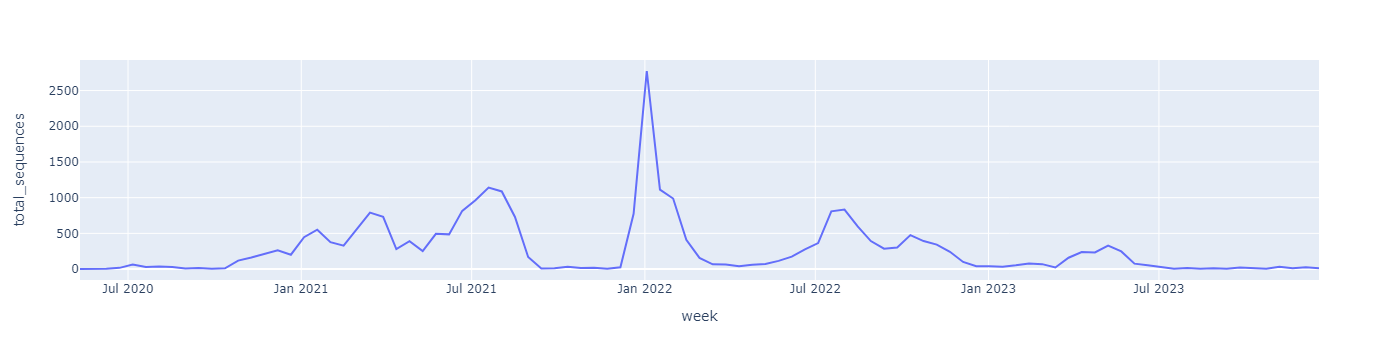

In [141]:
fig = px.line(phl_df, x='week', y='total_sequences')

fig.show()

In [145]:
vnm_df = df_analysis[df_analysis['country'] == 'Vietnam']

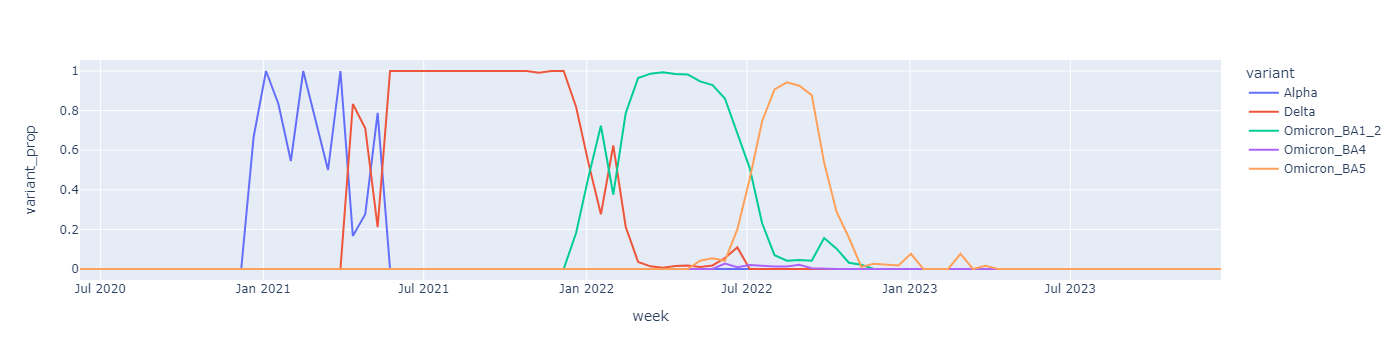

In [146]:
fig = px.line(vnm_df, x='week', y='variant_prop', color='variant')

fig.show()